In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,day_of_year,time_of_day,temp_mix03,temp_conv04,temp_initial00,obs_temp,input_obs,ice,snow,snowice
0,1,-1.220007,590.730964,-35.085181,-41.432575,0.0,0.4,2.439240,0.013584,36000000.0,...,1,2,5.278988,5.334504,5.406383,5.334504,-999.0,0.000000,0.0,0.0
1,2,-1.220007,590.730964,-35.085181,-41.432575,0.0,0.4,2.439240,0.013584,36000000.0,...,1,2,5.335771,5.372093,5.436557,5.372093,-999.0,0.000000,0.0,0.0
2,3,-1.220007,590.730964,-35.085181,-41.432575,0.0,0.4,2.439240,0.013584,36000000.0,...,1,2,5.425026,5.409226,5.436557,5.409226,-999.0,0.000000,0.0,0.0
3,4,-1.220007,590.730964,-35.085181,-41.432575,0.0,0.4,2.439240,0.013584,36000000.0,...,1,2,5.462485,5.440322,5.468520,5.440322,-999.0,0.000000,0.0,0.0
4,5,-1.220007,590.730964,-35.085181,-41.432575,0.0,0.4,2.439240,0.013584,36000000.0,...,1,2,5.486707,5.440322,5.498996,5.440322,-999.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3065970,21,3.860010,597.535984,35.016904,49.982107,0.0,0.4,9.313737,0.115895,36000000.0,...,363,0,0.208127,0.208127,0.193572,0.208127,-999.0,0.251441,0.0,0.0
3065971,22,3.860010,597.535984,35.016904,49.982107,0.0,0.4,9.313737,0.115895,36000000.0,...,363,0,0.246119,0.246119,0.231173,0.246119,-999.0,0.251441,0.0,0.0
3065972,23,3.860010,597.535984,35.016904,49.982107,0.0,0.4,9.313737,0.115895,36000000.0,...,363,0,0.290310,0.290310,0.281563,0.290310,-999.0,0.251441,0.0,0.0
3065973,24,3.860010,597.535984,35.016904,49.982107,0.0,0.4,9.313737,0.115895,36000000.0,...,363,0,0.328151,0.328151,0.350871,0.328151,-999.0,0.251441,0.0,0.0


In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 122639
Number of training points: 1839575


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [7]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
output_columns = ['temp_heat01']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [8]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (1839575, 14), X_test: (1226400, 14)
y_train: (1839575, 1), y_test: (1226400, 1)


In [9]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [10]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [11]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [12]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [13]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=14, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [14]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 1/1000 [00:23<6:37:08, 23.85s/it]

Epoch : 0, Train_loss: 0.019883672087957965, Test_loss: 0.00026513317529428795


  5%|▌         | 51/1000 [15:23<5:27:54, 20.73s/it]

Epoch : 50, Train_loss: 1.3006632790981e-06, Test_loss: 2.788127850608506e-06


 10%|█         | 101/1000 [30:22<5:09:58, 20.69s/it]

Epoch : 100, Train_loss: 8.622766626955131e-07, Test_loss: 1.0594346260521477e-07


 15%|█▌        | 151/1000 [45:35<4:54:15, 20.80s/it]

Epoch : 150, Train_loss: 6.556726680497434e-07, Test_loss: 5.2265189689041e-08


 20%|██        | 201/1000 [1:00:40<4:35:11, 20.66s/it]

Epoch : 200, Train_loss: 6.154644655576315e-07, Test_loss: 1.894718696610445e-07


 25%|██▌       | 251/1000 [1:15:54<4:21:02, 20.91s/it]

Epoch : 250, Train_loss: 4.999481684542803e-07, Test_loss: 3.903175609552275e-06


 30%|███       | 301/1000 [1:30:52<3:59:37, 20.57s/it]

Epoch : 300, Train_loss: 4.331926194905537e-07, Test_loss: 4.740374974913685e-08


 35%|███▌      | 351/1000 [1:46:04<3:44:42, 20.77s/it]

Epoch : 350, Train_loss: 3.790192043668012e-07, Test_loss: 8.978746912416963e-07


 40%|████      | 401/1000 [2:01:05<3:24:30, 20.49s/it]

Epoch : 400, Train_loss: 4.6260013572275684e-07, Test_loss: 5.0260967832857806e-08


 45%|████▌     | 451/1000 [2:16:12<3:10:04, 20.77s/it]

Epoch : 450, Train_loss: 3.5041575834833584e-07, Test_loss: 4.379547494348508e-06


 50%|█████     | 501/1000 [2:31:12<2:50:08, 20.46s/it]

Epoch : 500, Train_loss: 6.70668095053366e-09, Test_loss: 7.269007864930252e-09


 55%|█████▌    | 551/1000 [2:46:22<2:37:08, 21.00s/it]

Epoch : 550, Train_loss: 7.511896193065953e-09, Test_loss: 4.843114628871102e-09


 60%|██████    | 601/1000 [3:01:25<2:17:10, 20.63s/it]

Epoch : 600, Train_loss: 6.922795670791548e-09, Test_loss: 4.278827286179202e-09


 65%|██████▌   | 651/1000 [3:16:41<2:00:59, 20.80s/it]

Epoch : 650, Train_loss: 5.83589236590723e-09, Test_loss: 3.928102956569082e-09


 70%|███████   | 701/1000 [3:31:40<1:42:22, 20.54s/it]

Epoch : 700, Train_loss: 5.632834407837811e-09, Test_loss: 1.3552609828854136e-08


 75%|███████▌  | 751/1000 [3:46:54<1:26:18, 20.80s/it]

Epoch : 750, Train_loss: 5.3143494984596385e-09, Test_loss: 1.320903115128849e-08


 80%|████████  | 801/1000 [4:02:01<1:09:08, 20.85s/it]

Epoch : 800, Train_loss: 5.035729917395632e-09, Test_loss: 9.02601039170567e-09


 85%|████████▌ | 851/1000 [4:17:16<52:01, 20.95s/it]  

Epoch : 850, Train_loss: 5.130140016870425e-09, Test_loss: 2.890020956131529e-09


 90%|█████████ | 901/1000 [4:32:20<34:41, 21.02s/it]

Epoch : 900, Train_loss: 4.6182474671284784e-09, Test_loss: 2.897610433082341e-09


 95%|█████████▌| 951/1000 [4:47:33<17:10, 21.04s/it]

Epoch : 950, Train_loss: 4.589314177060579e-09, Test_loss: 2.158040038081011e-09


100%|██████████| 1000/1000 [5:02:07<00:00, 18.13s/it]


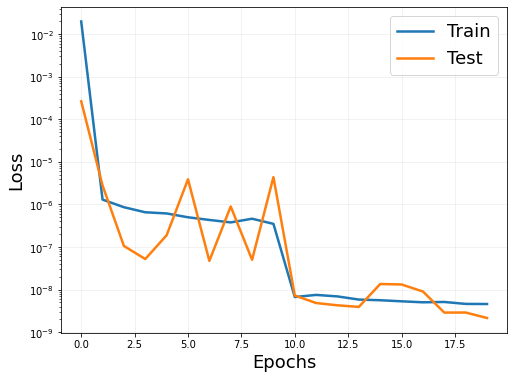

In [15]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [16]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_[:,0], pred_[:,0])
    
    l2_error_temp = l2_error(y_[:,0], pred_[:,0])
    return rmse_temp, l2_error_temp

In [17]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 0.00034932329640002195
L2 Error  of Temp: 4.377488577933207e-05


In [18]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.00032041757456224384
L2 Error  of Temp: 4.231420273076926e-05


# Saving Model

In [19]:
PATH = f"./saved_models/heating_model_time_HS.pth"
torch.save(model.state_dict(), PATH)

In [20]:
output_mean

array([5.15273647])